---
title: Run Seurat and get 3 clusters for random genes for 13th, 15th and 17th day.
authors:
- saksham.malhotra@elucidata.io
tags:
- SingleCell
- FreidaLab
- RPsvsNeurons
- metabolic genes
- random genes
- Seurat
created_at: 2019-05-31
updated_at: 2019-05-31
tldr: Runs Seurat for random genes only and computes 3 clusters. Checks overlap of cells assigned with cell types when all genes are used and limits clusters to 3. Does this multiple times to get distribution of cell types in the three clusters.
---

In [26]:
library(Seurat)
library(ggsci)
packageVersion("Seurat")

#set plot widths for the notebook
library(repr)
options(repr.plot.width=15, repr.plot.height=9)

[1] ‘2.3.0’

## Download 13th,15th and 17th day single cell datasets from GEO

In [3]:
system("wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE107nnn/GSE107122/suppl/GSE107122_RAW.tar", intern = TRUE)
system("tar -xvf GSE107122_RAW.tar", intern = TRUE)
system("gunzip GSM2861511_E135_Only_Cortical_Cells_DGE.txt.gz")

system("wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE107nnn/GSE107122/suppl/GSE107122_E155_Combined_Only_Cortical_Cells_DGE.txt.gz")
system("gunzip GSE107122_E155_Combined_Only_Cortical_Cells_DGE.txt.gz")
system("gunzip GSM2861514_E175_Only_Cortical_Cells_DGE.txt.gz")

character(0)

[1] "GSM2861510_E115_All_Cells_DGE.txt.gz"          
[2] "GSM2861510_E115_Only_Cortical_Cells_DGE.txt.gz"
[3] "GSM2861511_E135_All_Cells_DGE.txt.gz"          
[4] "GSM2861511_E135_Only_Cortical_Cells_DGE.txt.gz"
[5] "GSM2861514_E175_All_Cells_DGE.txt.gz"          
[6] "GSM2861514_E175_Only_Cortical_Cells_DGE.txt.gz"

### Function to run on a random set of genes, run the Seurat pipeline and get barcodes in each cluster (limit to three clusters)

In [2]:
run_random_get_barcodes <- function(data_matrix, Seurat_complete, resolution){
    require(Seurat)
    set.seed(Sys.time())
    random_gene_index <- sample (c(1:nrow(data_matrix)), size=4000, replace =F)
    print(head(random_gene_index))

    Seurat_object_random_data <- data_matrix[random_gene_index,]
    print(dim(Seurat_object_random_data))

    print("metabolic genes present in this data")
    print(sum(rownames(Seurat_object_random_data) %in% metabolic_genes))

    ### Create Seurat object
    Seurat_object_random <- CreateSeuratObject(raw.data = Seurat_object_random_data, 
                                                  min.cells = 3, min.genes = 200, project = "Seurat_object_random")
    
    mito.genes <- grep(pattern = "^MT-", x = rownames(x = Seurat_object_random@data), value = TRUE)
    percent.mito <- Matrix::colSums(Seurat_object_random@raw.data[mito.genes, ]) / Matrix::colSums(Seurat_object_random@raw.data)

    # AddMetaData adds columns to object@meta.data, and is a great place to stash QC stats
    Seurat_object_random <- AddMetaData(object = Seurat_object_random, metadata = percent.mito, col.name = "percent.mito")

    # We filter out cells that have unique gene counts over 2,500 or less than 200
    # Note that low.thresholds and high.thresholds are used to define a 'gate'
    # -Inf and Inf should be used if you don't want a lower or upper threshold.
    Seurat_object_random <- FilterCells(object = Seurat_object_random, subset.names = c("nGene", "percent.mito"),
                                        low.thresholds = c(200, -Inf), high.thresholds = c(2500, 0.05))

    Seurat_object_random <- NormalizeData(object = Seurat_object_random, normalization.method = "LogNormalize", scale.factor = 1e4)
    Seurat_object_random <- ScaleData(object = Seurat_object_random, vars.to.regress = c("nUMI", "percent.mito"))

    Seurat_object_random <- FindVariableGenes(object = Seurat_object_random, mean.function = ExpMean, dispersion.function = LogVMR, 
                                                 x.low.cutoff = 0, x.high.cutoff = 8.0, y.cutoff = 0.01, do.plot = F)


    Seurat_object_random <- RunPCA(object = Seurat_object_random, pc.genes = Seurat_object_random@var.genes, 
                                      do.print = FALSE, pcs.print = 1:5, genes.print = 5)

    Seurat_object_random_minclusters <- FindClusters(object = Seurat_object_random, 
                                                     reduction.type = "pca", dims.use = 1:20, resolution = resolution, 
                                                     print.output = 0, save.SNN = TRUE, force.recalc = T)


    print(paste("Number of clusters", length(unique(Seurat_object_random_minclusters@ident))), sep = ":")
    
    # save barcodes of each cluster into a list
    barcode_list = list()
    for(cl_no in unique(Seurat_object_random_minclusters@ident)){
        cluster_barcodes <- SubsetData(Seurat_object_random_minclusters, 
                                                       ident.use = cl_no)@cell.names
        barcode_list[[cl_no]] <- cluster_barcodes
    }
    
    gene_barcode_list <- list()
    gene_barcode_list[["barcodes"]] <- barcode_list
    gene_barcode_list[["genes"]] <- random_gene_index
    gene_barcode_list[["hv_genes"]] <- Seurat_object_random_minclusters@var.genes
    
    return(gene_barcode_list)
    }

### Find distribution of cell types in all clusters in each run
#### function to find how Neurons, IPs and RPs are distributed in the three clusters using complete Seurat object

In [3]:
get_cell_type_dist <- function(random_barcodes_3_clusters, Seurat_complete, cell_type){
    cell_type_barcodes <- SubsetData(Seurat_complete, ident.use = cell_type)@cell.names
    overlap_vector <- sapply(random_barcodes_3_clusters$barcodes, function(x){
        length(intersect(x, cell_type_barcodes))
    })
    overlap_vector <- overlap_vector/length(cell_type_barcodes)
    overlap_vector <- overlap_vector[c("0","1","2")]
    return(overlap_vector)
}

### Function to make overlap random distribution scatter plot

In [28]:
make_rand_dist_plot <- function(E_df, fill_list){

    E_df1 <- E_df[E_df$clustering == "random genes", ]
    E_df2 <- E_df[E_df$clustering == "metabolic genes", ]

    E_gg <- ggplot(E_df1,aes(x = `RPs in state 2`, y  = value, shape = clustering, 
                                      fill = variable, size = clustering)) + 
        ylab("Proportion of cells") + 
        xlab("Proportion of RPs in state 0") + 
        xlim(0,1) + ylim(0,1) + 
        geom_point(size = 3, color = "black") + 
        geom_point(data = E_df2, size = 5, aes(shape = clustering, fill = variable))+
        guides(shape = guide_legend(override.aes = list(size = 1)))+
        scale_fill_manual(values = fill_list, guide = F)+
        scale_shape_manual(values = c(23, 21), guide = F)+
        guides(size = F, shape = F) +
        theme(axis.line = element_line(size=1, colour = "black"),
              panel.grid.major = element_blank(),
              panel.grid.minor = element_blank(),
              panel.border = element_blank(),
              panel.background = element_blank(),
              axis.text.x=element_text(colour="black", size = 25, face = "bold"),
              axis.text.y=element_text(colour="black", size = 25, face = "bold"),
              legend.key=element_rect(fill="white", colour="white"),
              axis.title = element_text(colour="black", size = 25, face = "bold"),
              legend.text = element_text(size = 25, face = "bold"),
              legend.title = element_text(colour="black", size=25, face="bold"),
              axis.ticks.length=unit(.2, "cm"))

    E_gg_dummy <- ggplot(E_df,aes(x = `RPs in state 2`, y  = value, color = variable, 
                                      shape = clustering, size = clustering)) + 
        geom_point() + 
        ylab("proportion of cells") + 
        xlab("proportion of RPs in state 0") +
        guides(color = guide_legend(override.aes = list(size= 3.5)))+
        scale_color_manual(name = "", values = fill_list, labels = c("Neurons in state 0" = "Neurons in state 2",
                                                                      "IPs in state 1" = "IPs in state 1"))+ 
        scale_shape_manual(name = "", values = c("metabolic genes" = 23, "random genes" = 21)) +
        scale_size_manual(name = "", values = c("metabolic genes" = 4, "random genes" = 1.5))+ 
        theme(legend.key=element_rect(fill="white", colour="white"),
              legend.position = "right", legend.direction = "vertical", 
              legend.justification = "top",
              legend.text = element_text(size = 22, face = "bold"),
              legend.title = element_text(colour="black", size=13, face="bold"),
              axis.ticks.length=unit(.2, "cm"))
    g_legend <- function(a.gplot){
      tmp <- ggplot_gtable(ggplot_build(a.gplot))
      leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
      legend <- tmp$grobs[[leg]]
      return(legend)
    }
    legend <- g_legend(E_gg_dummy)
    library(gridExtra)
    pp <- arrangeGrob(E_gg ,legend,
                      widths=c(3/2, 1/2),
                       ncol = 2)
    return(pp)
}

## 13th day 

### Read the 13th day dataset

In [5]:
E135_Cortical_data <- read.table("GSM2861511_E135_Only_Cortical_Cells_DGE.txt",sep= "\t", header=TRUE, row.names=1)

In [6]:
head(E135_Cortical_data)

,GTAGCAATTTCT,TACTAGATGCTA,TATCAGCAGATT,TACAGGCCCGTC,TGATATACACTT,ATTTCGCGTGAA,GGTTTGTCCTTT,AACGTCACATCC,CCTATCCTTTGC,AAATTCGTCGGT,⋯,GCCGATAGAGCN,TCAATCCGCGGG,AGTGTGATAGTG,TCATTGCGGCTG,CTCTAGCTTCCG,CTAACGCAAGAC,GTGTTTGCGGTA,ATGTTGCATGAC,ATACCAGCTAAG,ATGTTGCATGAN
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0610007N19Rik,0,0,2,0,0,0,0,0,0,0,⋯,0,2,0,0,0,0,0,0,0,0
0610007P14Rik,0,0,1,1,0,1,0,1,0,0,⋯,0,0,0,1,1,0,0,0,0,0
0610009B22Rik,0,1,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0610009D07Rik,0,2,1,0,2,0,4,2,0,2,⋯,1,0,0,1,1,0,0,0,0,0
0610009E02Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [7]:
dim(E135_Cortical_data)

[1] 17082  1137

### Run 1300 iterations of the above function and store cluster barcodes in a list

In [11]:
E135_random_run_barcodes <- list()

In [13]:
for(i in (length(E135_random_run_barcodes)+1):1500){
    print(paste("iteration:", i))
    E135_random_run_barcodes[[i]] <- run_random_get_barcodes(E135_Cortical_data, E135_Cortical,0.4)
}

[1] "iteration: 1"
[1] "iteration: 2"
[1] "iteration: 3"
[1] "iteration: 4"
[1] "iteration: 5"
[1] "iteration: 6"
[1] "iteration: 7"
[1] "iteration: 8"
[1] "iteration: 9"
[1] "iteration: 10"
[1] "iteration: 11"
[1] "iteration: 12"
[1] "iteration: 13"
[1] "iteration: 14"
[1] "iteration: 15"
[1] "iteration: 16"
[1] "iteration: 17"
[1] "iteration: 18"
[1] "iteration: 19"
[1] "iteration: 20"
[1] "iteration: 21"
[1] "iteration: 22"
[1] "iteration: 23"
[1] "iteration: 24"
[1] "iteration: 25"
[1] "iteration: 26"
[1] "iteration: 27"
[1] "iteration: 28"
[1] "iteration: 29"
[1] "iteration: 30"
[1] "iteration: 31"
[1] "iteration: 32"
[1] "iteration: 33"
[1] "iteration: 34"
[1] "iteration: 35"
[1] "iteration: 36"
[1] "iteration: 37"
[1] "iteration: 38"
[1] "iteration: 39"
[1] "iteration: 40"
[1] "iteration: 41"
[1] "iteration: 42"
[1] "iteration: 43"
[1] "iteration: 44"
[1] "iteration: 45"
[1] "iteration: 46"
[1] "iteration: 47"
[1] "iteration: 48"
[1] "iteration: 49"
[1] "iteration: 50"
[1] "iter

#### take clusters with length 3 only

In [ ]:
E135_random_run_barcodes <- E135_random_run_barcodes[sapply(E135_random_run_barcodes, function(x) length(x$barcodes)==3)]

In [8]:
length(E135_random_run_barcodes)

[1] 1291

### Read 13th day Seurat object from previous analysis

In [12]:
E135_Cortical <- readRDS("E135_Cortical.rds")
table(E135_Cortical@ident)


    IPs Neurons     RPs 
    245     656     139 

### Get overlaps for 3 clusters in random iterations with cell types for RPS

In [13]:
E135_random_run_barcode_RPs <- list()
for(i in 1:length(E135_random_run_barcodes)){
    E135_random_run_barcode_RPs[[i]] <- get_cell_type_dist(E135_random_run_barcodes[[i]], 
                                                            E135_Cortical, "RPs")
}

In [10]:
E135_random_run_barcode_RPs_df <- data.frame(do.call(rbind, E135_random_run_barcode_RPs))
colnames(E135_random_run_barcode_RPs_df) <- c(0,1,2)
dim(E135_random_run_barcode_RPs_df)
head(E135_random_run_barcode_RPs_df)

[1] 1291    3

,0,1,2
,<dbl>,<dbl>,<dbl>
1,0.000000000,0.748201439,0.07194245
2,0.000000000,0.007194245,0.81294964
3,0.014388489,0.014388489,0.76258993
4,0.021582734,0.021582734,0.75539568
5,0.007194245,0.769784173,0.05755396
6,0.000000000,0.014388489,0.79136691


### Get overlaps for 3 clusters in random iterations with cell types for IPs

In [14]:
E135_random_run_barcode_IPs <- list()
for(i in 1:length(E135_random_run_barcodes)){
    E135_random_run_barcode_IPs[[i]] <- get_cell_type_dist(E135_random_run_barcodes[[i]], 
                                                            E135_Cortical, "IPs")
}

In [ ]:
saveRDS(E135_random_run_barcode_IPs, "E135_random_run_barcode_IPs.rds")

In [16]:
E135_random_run_barcode_IPs_df <- data.frame(do.call(rbind, E135_random_run_barcode_IPs))
colnames(E135_random_run_barcode_IPs_df) <- c(0,1,2)
dim(E135_random_run_barcode_IPs_df)
head(E135_random_run_barcode_IPs_df)

[1] 1291    3

,0,1,2
,<dbl>,<dbl>,<dbl>
1,0.000000000,0.3632653,0.4653061
2,0.000000000,0.4326531,0.3959184
3,0.004081633,0.4448980,0.3469388
4,0.000000000,0.4408163,0.3510204
5,0.000000000,0.3632653,0.4530612
6,0.012244898,0.4285714,0.3632653


### Get overlaps for 3 clusters in random iterations with cell types for Neurons

In [18]:
E135_random_run_barcode_Neurons <- list()
for(i in 1:length(E135_random_run_barcodes)){
    E135_random_run_barcode_Neurons[[i]] <- get_cell_type_dist(E135_random_run_barcodes[[i]], 
                                                            E135_Cortical, "Neurons")
}

In [19]:
E135_random_run_barcode_Neurons_df <- data.frame(do.call(rbind, E135_random_run_barcode_Neurons))
colnames(E135_random_run_barcode_Neurons_df) <- c(0,1,2)
dim(E135_random_run_barcode_Neurons_df)
head(E135_random_run_barcode_Neurons_df)

[1] 1291    3

,0,1,2
,<dbl>,<dbl>,<dbl>
1,0.6753049,0.0000000,0.1189024
2,0.6371951,0.1631098,0.0000000
3,0.6539634,0.1234756,0.0000000
4,0.6128049,0.1768293,0.0000000
5,0.6554878,0.0000000,0.1432927
6,0.6753049,0.1295732,0.0000000


### Make overlap scatter plot for Neurons in state1, RPs in state2 and IPs in state 1

In [20]:
E135_overlap_df <- data.frame(Neurons = E135_random_run_barcode_Neurons_df['0'], 
                      RPs = E135_random_run_barcode_RPs_df['2'],
                      IPs = E135_random_run_barcode_IPs_df['1'])
# add overlap proportions from metabolic genes clustering 
E135_overlap_df[(nrow(E135_overlap_df) + 1), c(1,2,3)] <- c(0.7, 0.86, 0.39)
colnames(E135_overlap_df) = c("Neurons in state 0", "RPs in state 2", "IPs in state 1")
E135_overlap_df$clustering <- c(rep("random genes", nrow(E135_overlap_df) -1), "metabolic genes")
head(E135_overlap_df)

,Neurons in state 0,RPs in state 2,IPs in state 1,clustering
,<dbl>,<dbl>,<dbl>,<chr>
1,0.6753049,0.07194245,0.3632653,random genes
2,0.6371951,0.81294964,0.4326531,random genes
3,0.6539634,0.76258993,0.4448980,random genes
4,0.6128049,0.75539568,0.4408163,random genes
5,0.6554878,0.05755396,0.3632653,random genes
6,0.6753049,0.79136691,0.4285714,random genes


In [23]:
library(reshape2)
E135_overlap_df_tall <- melt(E135_overlap_df, id.vars=c("RPs in state 2", "clustering"))
head(E135_overlap_df_tall)

,RPs in state 2,clustering,variable,value
,<dbl>,<chr>,<fct>,<dbl>
1,0.07194245,random genes,Neurons in state 0,0.6753049
2,0.81294964,random genes,Neurons in state 0,0.6371951
3,0.76258993,random genes,Neurons in state 0,0.6539634
4,0.75539568,random genes,Neurons in state 0,0.6128049
5,0.05755396,random genes,Neurons in state 0,0.6554878
6,0.79136691,random genes,Neurons in state 0,0.6753049


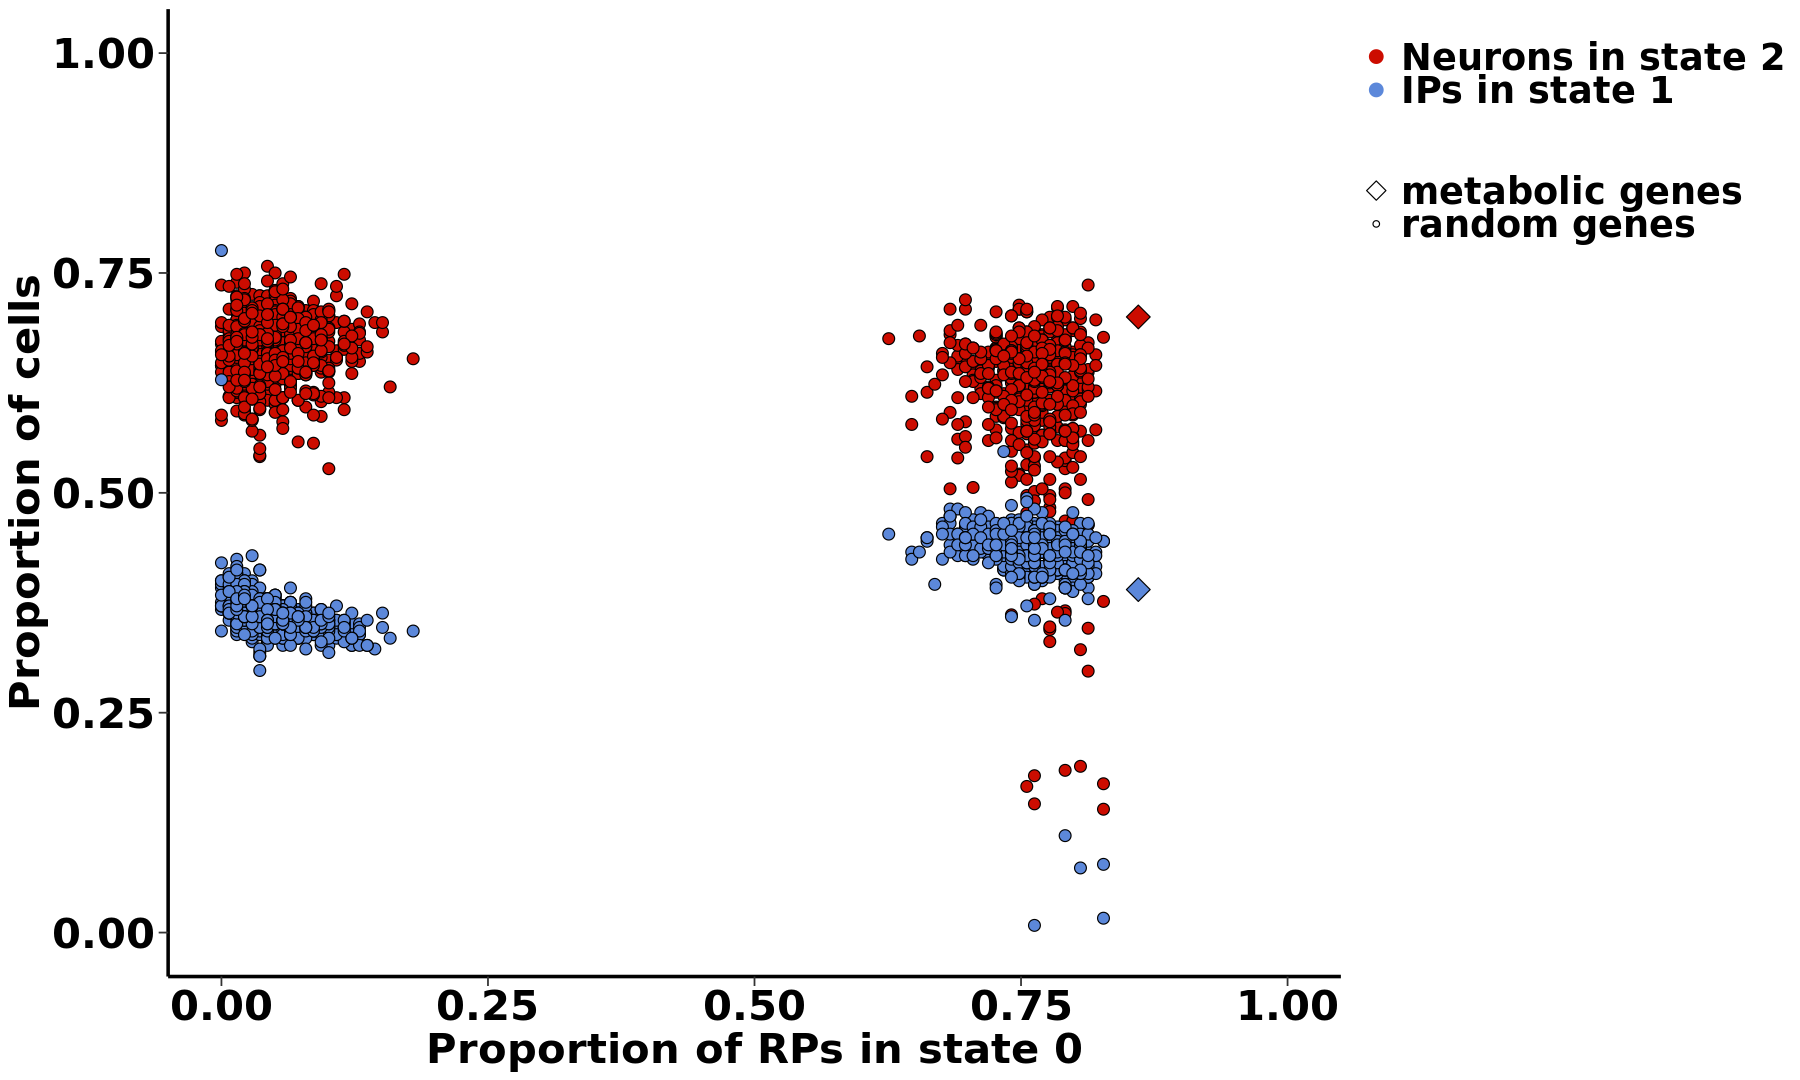

In [29]:
p <- make_rand_dist_plot(E135_overlap_df_tall, fill_list = c("Neurons in state 0" = pal_startrek("uniform")(7)[1], 
                                                "IPs in state 1" = pal_startrek("uniform")(7)[2]))
grid.arrange(p)

## 15th day data

### Read 15th day data

In [30]:
E155_Cortical_data <- read.table("GSE107122_E155_Combined_Only_Cortical_Cells_DGE.txt",sep= "\t", header=TRUE, row.names=1)
head(E155_Cortical_data)

,CTGATGGTCTTT,CACCGTTAGGAC,TAATTCATTCTC,TGAGATTATCTT,CCCGGCGGCCAC,GTCCTTCCATGT,AGCTCGTTTCCA,CATATCCATCGC,TTACCTTCTCTG,ACCTCTCACTTA,⋯,CCAAGGTCCCAA,ACCCCTGCGTGT,AGACGGTTTACG,TAGAGCCCTTCG,CTGAAGCCGGCC,CGCCTCCGCTTA,TCACATTCTACT,TCTGCGGCCGGA,AGAAGGCTATAT,GGGGCATTCGCA
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0610007N19Rik,0,0,1,0,3,0,0,0,0,0,⋯,0,1,0,0,0,0,0,0,0,1
0610007P14Rik,0,1,0,2,1,1,1,3,0,0,⋯,0,1,0,0,0,0,0,0,1,0
0610009B22Rik,2,1,0,0,1,0,0,0,0,2,⋯,0,0,1,0,0,0,0,0,0,0
0610009D07Rik,4,1,0,3,4,2,3,0,7,2,⋯,1,1,0,2,1,1,0,0,0,0
0610009E02Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Run 1300 iterations on the above to get 3 clusters 

In [41]:
E155_random_run_barcodes <- list()

In [43]:
for(i in (length(E155_random_run_barcodes)+1):1300){
    print(paste("iteration:", i))
    E155_random_run_barcodes[[i]] <- run_random_get_barcodes(E155_Cortical_data, E155_Cortical, 0.25)
}

[1] "iteration: 1"
[1] "iteration: 2"
[1] "iteration: 3"
[1] "iteration: 4"
[1] "iteration: 5"
[1] "iteration: 6"
[1] "iteration: 7"
[1] "iteration: 8"
[1] "iteration: 9"
[1] "iteration: 10"
[1] "iteration: 11"
[1] "iteration: 12"
[1] "iteration: 13"
[1] "iteration: 14"
[1] "iteration: 15"
[1] "iteration: 16"
[1] "iteration: 17"
[1] "iteration: 18"
[1] "iteration: 19"
[1] "iteration: 20"
[1] "iteration: 21"
[1] "iteration: 22"
[1] "iteration: 23"
[1] "iteration: 24"
[1] "iteration: 25"
[1] "iteration: 26"
[1] "iteration: 27"
[1] "iteration: 28"
[1] "iteration: 29"
[1] "iteration: 30"
[1] "iteration: 31"
[1] "iteration: 32"
[1] "iteration: 33"
[1] "iteration: 34"
[1] "iteration: 35"
[1] "iteration: 36"
[1] "iteration: 37"
[1] "iteration: 38"
[1] "iteration: 39"
[1] "iteration: 40"
[1] "iteration: 41"
[1] "iteration: 42"
[1] "iteration: 43"
[1] "iteration: 44"
[1] "iteration: 45"
[1] "iteration: 46"
[1] "iteration: 47"
[1] "iteration: 48"
[1] "iteration: 49"
[1] "iteration: 50"
[1] "iter

#### Take clusters with length 3 only

In [38]:
E155_random_run_barcodes <- E155_random_run_barcodes[sapply(E155_random_run_barcodes, function(x) length(x$barcodes)==3)]

In [46]:
length(E155_random_run_barcodes)

[1] 1342

### Get overlaps for 3 clusters in random iterations with cell types for RPs

In [47]:
E155_random_run_barcode_RPs <- list()
for(i in 1:length(E155_random_run_barcodes)){
    E155_random_run_barcode_RPs[[i]] <- get_cell_type_dist(E155_random_run_barcodes[[i]], 
                                                            E155_Cortical, "RPs")
}

In [63]:
E155_random_run_barcode_RPs_df <- data.frame(do.call(rbind, E155_random_run_barcode_RPs))
colnames(E155_random_run_barcode_RPs_df) <- c(0,1,2)
dim(E155_random_run_barcode_RPs_df)
head(E155_random_run_barcode_RPs_df)

[1] 1342    3

,0,1,2
,<dbl>,<dbl>,<dbl>
1,0,0.03045685,0.8578680
2,0,0.00000000,0.8832487
3,0,0.88324873,0.0000000
4,0,0.00000000,0.8781726
5,0,0.86802030,0.0000000
6,0,0.08629442,0.8071066


### Get overlaps for 3 clusters in random iterations with cell types for IPs

In [49]:
E155_random_run_barcode_IPs <- list()
for(i in 1:length(E155_random_run_barcodes)){
    E155_random_run_barcode_IPs[[i]] <- get_cell_type_dist(E155_random_run_barcodes[[i]], 
                                                            E155_Cortical, "IPs")
}

In [64]:
E155_random_run_barcode_IPs_df <- data.frame(do.call(rbind, E155_random_run_barcode_IPs))
colnames(E155_random_run_barcode_IPs_df) <- c(0,1,2)
dim(E155_random_run_barcode_IPs_df)
head(E155_random_run_barcode_IPs_df)

[1] 1342    3

,0,1,2
,<dbl>,<dbl>,<dbl>
1,0.002087683,0.803757829,0.008350731
2,0.010438413,0.002087683,0.772442589
3,0.054279749,0.762004175,0.000000000
4,0.475991649,0.002087683,0.327766180
5,0.237995825,0.530271399,0.000000000
6,0.004175365,0.803757829,0.002087683


### Get overlaps for 3 clusters in random iterations with cell types for Neurons

In [61]:
E155_random_run_barcode_Neurons <- list()
for(i in 1:length(E155_random_run_barcodes)){
    E155_random_run_barcode_Neurons[[i]] <- get_cell_type_dist(E155_random_run_barcodes[[i]], 
                                                            E155_Cortical, "Neurons")
}

In [65]:
E155_random_run_barcode_Neurons_df <- data.frame(do.call(rbind, E155_random_run_barcode_Neurons))
colnames(E155_random_run_barcode_Neurons_df) <- c(0,1,2)
dim(E155_random_run_barcode_Neurons_df)
head(E155_random_run_barcode_Neurons_df)

[1] 1342    3

,0,1,2
,<dbl>,<dbl>,<dbl>
1,0.6365953,0.17991845,0.03414883
2,0.3924567,0.36850153,0.08868502
3,0.4877676,0.05912334,0.29867482
4,0.4016310,0.41131498,0.03771662
5,0.5886850,0.03771662,0.20438328
6,0.6483180,0.16156983,0.03669725


### Make overlap scatter plot for Neurons in state1, RPs in state2 and IPs in state 1

In [66]:
E155_overlap_df <- data.frame(Neurons = E155_random_run_barcode_Neurons_df['0'], 
                      RPs = E155_random_run_barcode_RPs_df['2'],
                      IPs = E155_random_run_barcode_IPs_df['1'])
# get metabolic genes overlaps from previous analysis
E155_overlap_df[(nrow(E155_overlap_df) + 1), c(1,2,3)] <- c(0.67, 0.95, 0.97)
colnames(E155_overlap_df) = c("Neurons in state 0", "RPs in state 2", "IPs in state 1")
E155_overlap_df$clustering <- c(rep("random genes", nrow(E155_overlap_df) -1), "metabolic genes")
head(E155_overlap_df)

,Neurons in state 0,RPs in state 2,IPs in state 1,clustering
,<dbl>,<dbl>,<dbl>,<chr>
1,0.6365953,0.8578680,0.803757829,random genes
2,0.3924567,0.8832487,0.002087683,random genes
3,0.4877676,0.0000000,0.762004175,random genes
4,0.4016310,0.8781726,0.002087683,random genes
5,0.5886850,0.0000000,0.530271399,random genes
6,0.6483180,0.8071066,0.803757829,random genes


In [67]:
E155_overlap_df_tall <- melt(E155_overlap_df, id.vars=c("RPs in state 2", "clustering"))
head(E155_overlap_df_tall)

,RPs in state 2,clustering,variable,value
,<dbl>,<chr>,<fct>,<dbl>
1,0.8578680,random genes,Neurons in state 0,0.6365953
2,0.8832487,random genes,Neurons in state 0,0.3924567
3,0.0000000,random genes,Neurons in state 0,0.4877676
4,0.8781726,random genes,Neurons in state 0,0.4016310
5,0.0000000,random genes,Neurons in state 0,0.5886850
6,0.8071066,random genes,Neurons in state 0,0.6483180


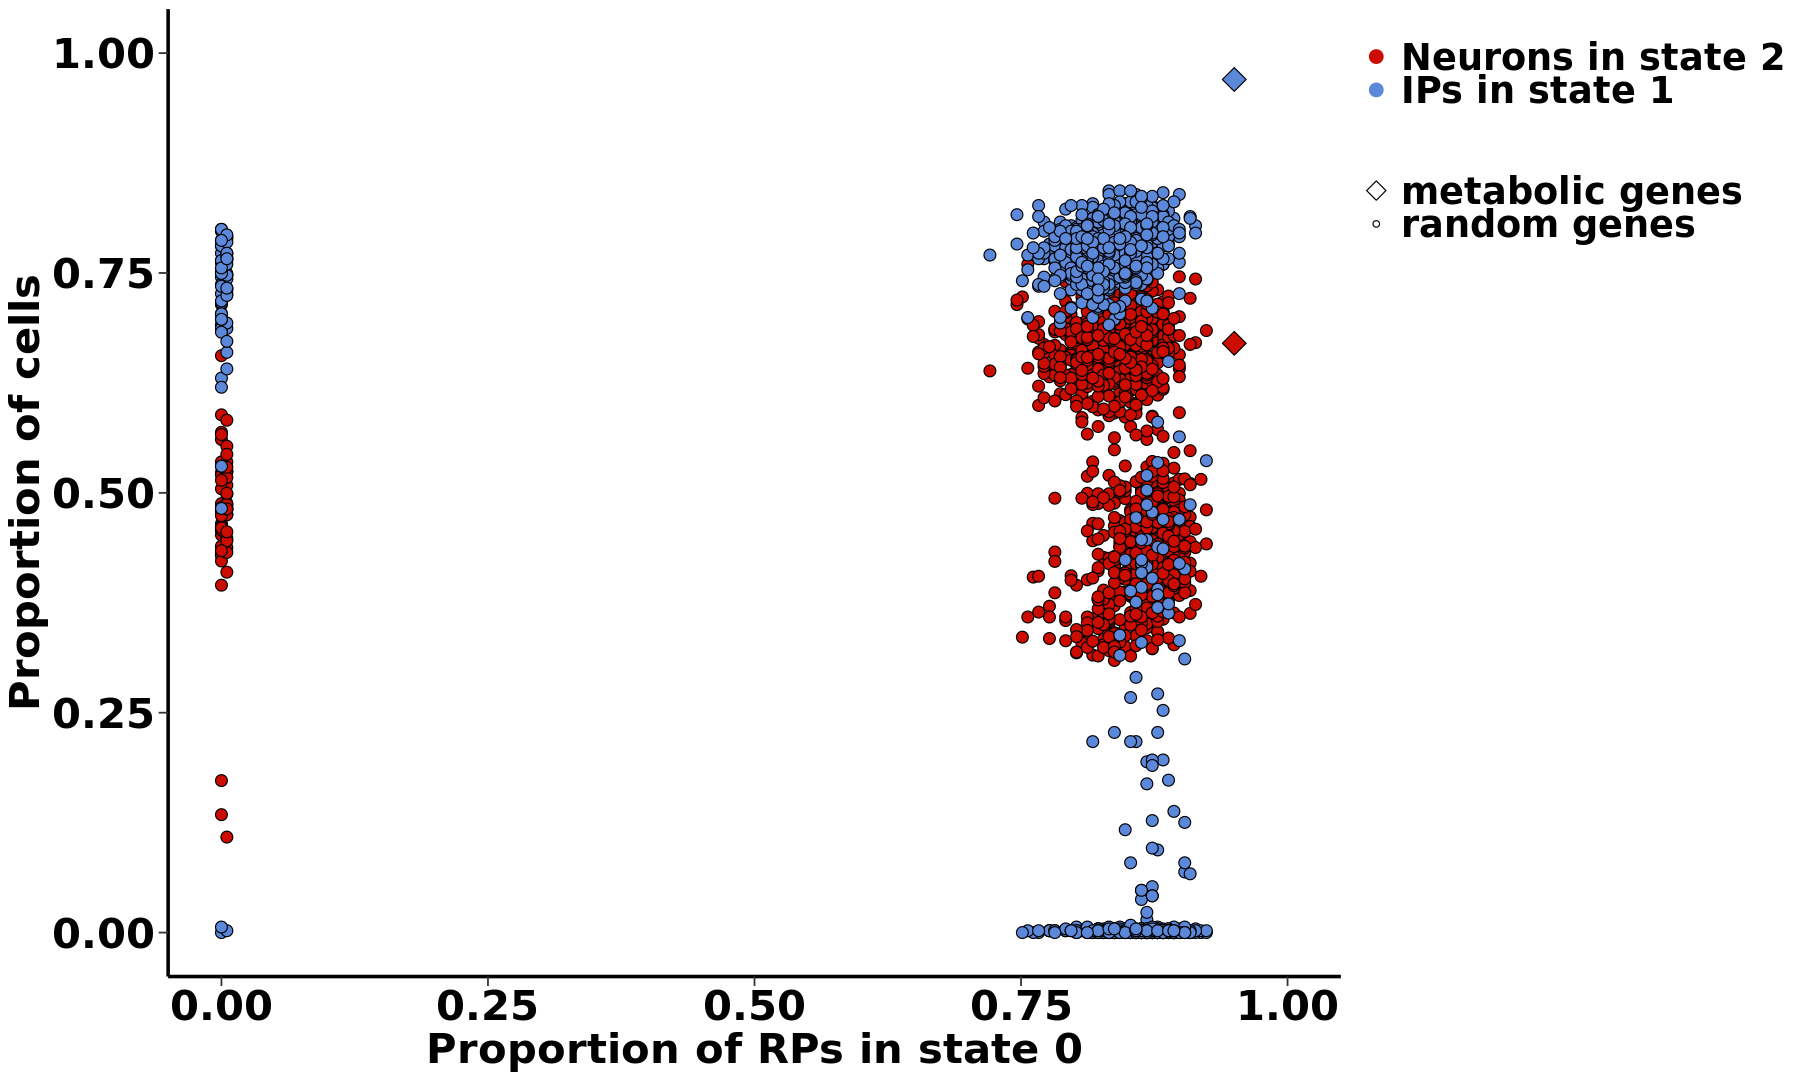

In [68]:
p <- make_rand_dist_plot(E155_overlap_df_tall, fill_list = c("Neurons in state 0" = pal_startrek("uniform")(7)[1], 
                                                "IPs in state 1" = pal_startrek("uniform")(7)[2]))
grid.arrange(p)

## 17th day data

### Read 17th day data

In [69]:
E175_Cortical_data <- read.table("GSM2861514_E175_Only_Cortical_Cells_DGE.txt",sep= "\t", header=TRUE, row.names=1)
head(E175_Cortical_data)

,CGTTTAGTTTAC,TCTAGAACAACG,ACCTTTGTTCGT,TTGTCTTCTTCG,TAAAATATCGCC,GTACCCTATTTC,GCACATTACCCA,CCTCGCGCGGCT,TTAATTTTGCCT,GTCTTGCGTTTT,⋯,CCGGAGTTATGG,GAATGGAACGCG,AATGGGATTTAC,CGGGGGTCACAC,ACTAAGCCGCTT,CTTAGGGGGGCT,GCTATCTGGTTG,CACTATTGTCAA,CGGACGTTCGTC,TCGAGTTAAGTC
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0610005C13Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0610007N19Rik,0,0,0,0,0,0,0,2,0,0,⋯,0,0,0,0,0,0,0,0,0,0
0610007P14Rik,2,1,1,1,0,1,0,0,0,0,⋯,0,0,0,0,1,0,0,0,0,0
0610009B22Rik,1,1,0,0,0,0,0,1,1,0,⋯,0,0,1,0,0,0,0,0,0,0
0610009D07Rik,2,3,0,3,0,2,1,2,1,5,⋯,1,1,0,0,1,2,0,0,0,0
0610009E02Rik,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### Run 1300 iterations on the above to get 3 clusters 

In [ ]:
E175_random_run_barcodes <- list()
for(i in (length(E175_random_run_barcodes)+1):1500){
    if(i%%100 == 0)
        saveRDS(E175_random_run_barcodes, "E175_random_run_barcodes.rds")
    print(paste("iteration:", i))
    E175_random_run_barcodes[[i]] <- run_random_get_barcodes(E175_Cortical_data, E175_Cortical, 0.25)
}

In [ ]:
E175_random_run_barcodes <- E175_random_run_barcodes[sapply(E175_random_run_barcodes, 
                                                            function(x) length(x$barcodes)==2)]

In [72]:
length(E175_random_run_barcodes)

[1] 1362

### Get overlaps for 3 clusters in random iterations with cell types for RPs

In [73]:
E175_random_run_barcode_RPs <- list()
for(i in 1:length(E175_random_run_barcodes)){
    E175_random_run_barcode_RPs[[i]] <- get_cell_type_dist(E175_random_run_barcodes[[i]], 
                                                            E175_Cortical, "RPs")
}

In [75]:
E175_random_run_barcode_RPs_df <- data.frame(do.call(rbind, E175_random_run_barcode_RPs))
colnames(E175_random_run_barcode_RPs_df) <- c(0,1)
dim(E175_random_run_barcode_RPs_df)
head(E175_random_run_barcode_RPs_df)

[1] 1362    2

,0,1
,<dbl>,<dbl>
1,0.7464789,0.16901408
2,0.8028169,0.12676056
3,0.7464789,0.09859155
4,0.7183099,0.18309859
5,0.8028169,0.11267606
6,0.8169014,0.08450704


### Get overlaps for 3 clusters in random iterations with cell types for Neurons

In [77]:
E175_random_run_barcode_Neurons <- list()
for(i in 1:length(E175_random_run_barcodes)){
    E175_random_run_barcode_Neurons[[i]] <- get_cell_type_dist(E175_random_run_barcodes[[i]], 
                                                            E175_Cortical, "Neurons")
}

In [76]:
E175_random_run_barcode_Neurons_df <- data.frame(do.call(rbind, E175_random_run_barcode_Neurons))
colnames(E175_random_run_barcode_Neurons_df) <- c(0,1)
dim(E175_random_run_barcode_Neurons_df)
head(E175_random_run_barcode_Neurons_df)

[1] 1362    2

,0,1
,<dbl>,<dbl>
1,0,0.8369427
2,0,0.8292994
3,0,0.8191083
4,0,0.8458599
5,0,0.8496815
6,0,0.8229299


### Make overlap scatter plot for Neurons in state1, RPs in state2 

In [78]:
E175_overlap_df <- data.frame(Neurons = E175_random_run_barcode_Neurons_df['1'], RPs = E175_random_run_barcode_RPs_df['0'])
# get metabolic genes overlap from previous analysis
E175_overlap_df[(nrow(E175_overlap_df) + 1), c(1,2)] <- c(0.80, 0.98)
colnames(E175_overlap_df) <- c("Neurons in state 2", "RPs in state 0")
E175_overlap_df$clustering <- c(rep("random genes", nrow(E175_overlap_df) -1), "metabolic genes")
head(E175_overlap_df)

,Neurons in state 2,RPs in state 0,clustering
,<dbl>,<dbl>,<chr>
1,0.8369427,0.7464789,random genes
2,0.8292994,0.8028169,random genes
3,0.8191083,0.7464789,random genes
4,0.8458599,0.7183099,random genes
5,0.8496815,0.8028169,random genes
6,0.8229299,0.8169014,random genes


In [80]:
E175_df_overlap_tall <- melt(E175_overlap_df, id.vars=c("RPs in state 0", "clustering"))
head(E175_df_overlap_tall)

,RPs in state 0,clustering,variable,value
,<dbl>,<chr>,<fct>,<dbl>
1,0.7464789,random genes,Neurons in state 2,0.8369427
2,0.8028169,random genes,Neurons in state 2,0.8292994
3,0.7464789,random genes,Neurons in state 2,0.8191083
4,0.7183099,random genes,Neurons in state 2,0.8458599
5,0.8028169,random genes,Neurons in state 2,0.8496815
6,0.8169014,random genes,Neurons in state 2,0.8229299


In [83]:
E_df <- E175_df_overlap_tall
fill_list = c("Neurons in state 2" = pal_startrek("uniform")(7)[1])
E_df1 <- E_df[E_df$clustering == "random genes", ]
E_df2 <- E_df[E_df$clustering == "metabolic genes", ]


E_gg <- ggplot(E_df1,aes(x = `RPs in state 0`, y  = value, shape = clustering, 
                                      fill = variable, size = clustering)) + 
    ylab("Proportion of cells") + 
    xlab("Proportion of RPs in state 0") +
    xlim(0,1) + ylim(0,1) + 
    geom_point(size = 3, color = "black") + 
    geom_point(data = E_df2, size = 5, aes(shape = clustering, fill = variable))+
    guides(shape = guide_legend(override.aes = list(size = 1)))+
    scale_fill_manual(values = fill_list, guide = F)+
    scale_shape_manual(values = c(23, 21), guide = F)+
    guides(size = F, shape = F) +
    theme(axis.line = element_line(size=1, colour = "black"),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x=element_text(colour="black", size = 25, face = "bold"),
          axis.text.y=element_text(colour="black", size = 25, face = "bold"),
          legend.key=element_rect(fill="white", colour="white"),
          axis.title = element_text(colour="black", size = 25, face = "bold"),
          legend.text = element_text(size = 25, face = "bold"),
          legend.title = element_text(colour="black", size=25, face="bold"),
          axis.ticks.length=unit(.2, "cm"))

E_gg_dummy <- ggplot(E_df,aes(x = `RPs in state 0`, y  = value, color = variable, 
                                  shape = clustering, size = clustering)) + 
    geom_point() + 
    ylab("proportion of cells") + 
    guides(shape = guide_legend(order = 2, override.aes = list(size = 3)), color = guide_legend(order = 1,override.aes = list(size=3.5))) + 
    xlab("proportion of RPs in state 0") +
    scale_color_manual(name = "", values = fill_list)+ 
    scale_shape_manual(name = "", values = c("metabolic genes" = 23, "random genes" = 21)) +
    scale_size_manual(name = "", values = c("metabolic genes" = 4, "random genes" = 1.5))+ 
    theme(legend.key=element_rect(fill="white", colour="white"),
          legend.position = "right", legend.direction = "vertical", 
          legend.justification = "top",
          legend.text = element_text(size = 22, face = "bold"),
          legend.title = element_text(colour="black", size=10, face="bold"),
          axis.ticks.length=unit(.2, "cm"))
g_legend <- function(a.gplot){
  tmp <- ggplot_gtable(ggplot_build(a.gplot))
  leg <- which(sapply(tmp$grobs, function(x) x$name) == "guide-box")
  legend <- tmp$grobs[[leg]]
  return(legend)
}
legend <- g_legend(E_gg_dummy)
library(gridExtra)
pp <- arrangeGrob(E_gg ,legend,
                  widths=c(3/2, 1/2),
                   ncol = 2)


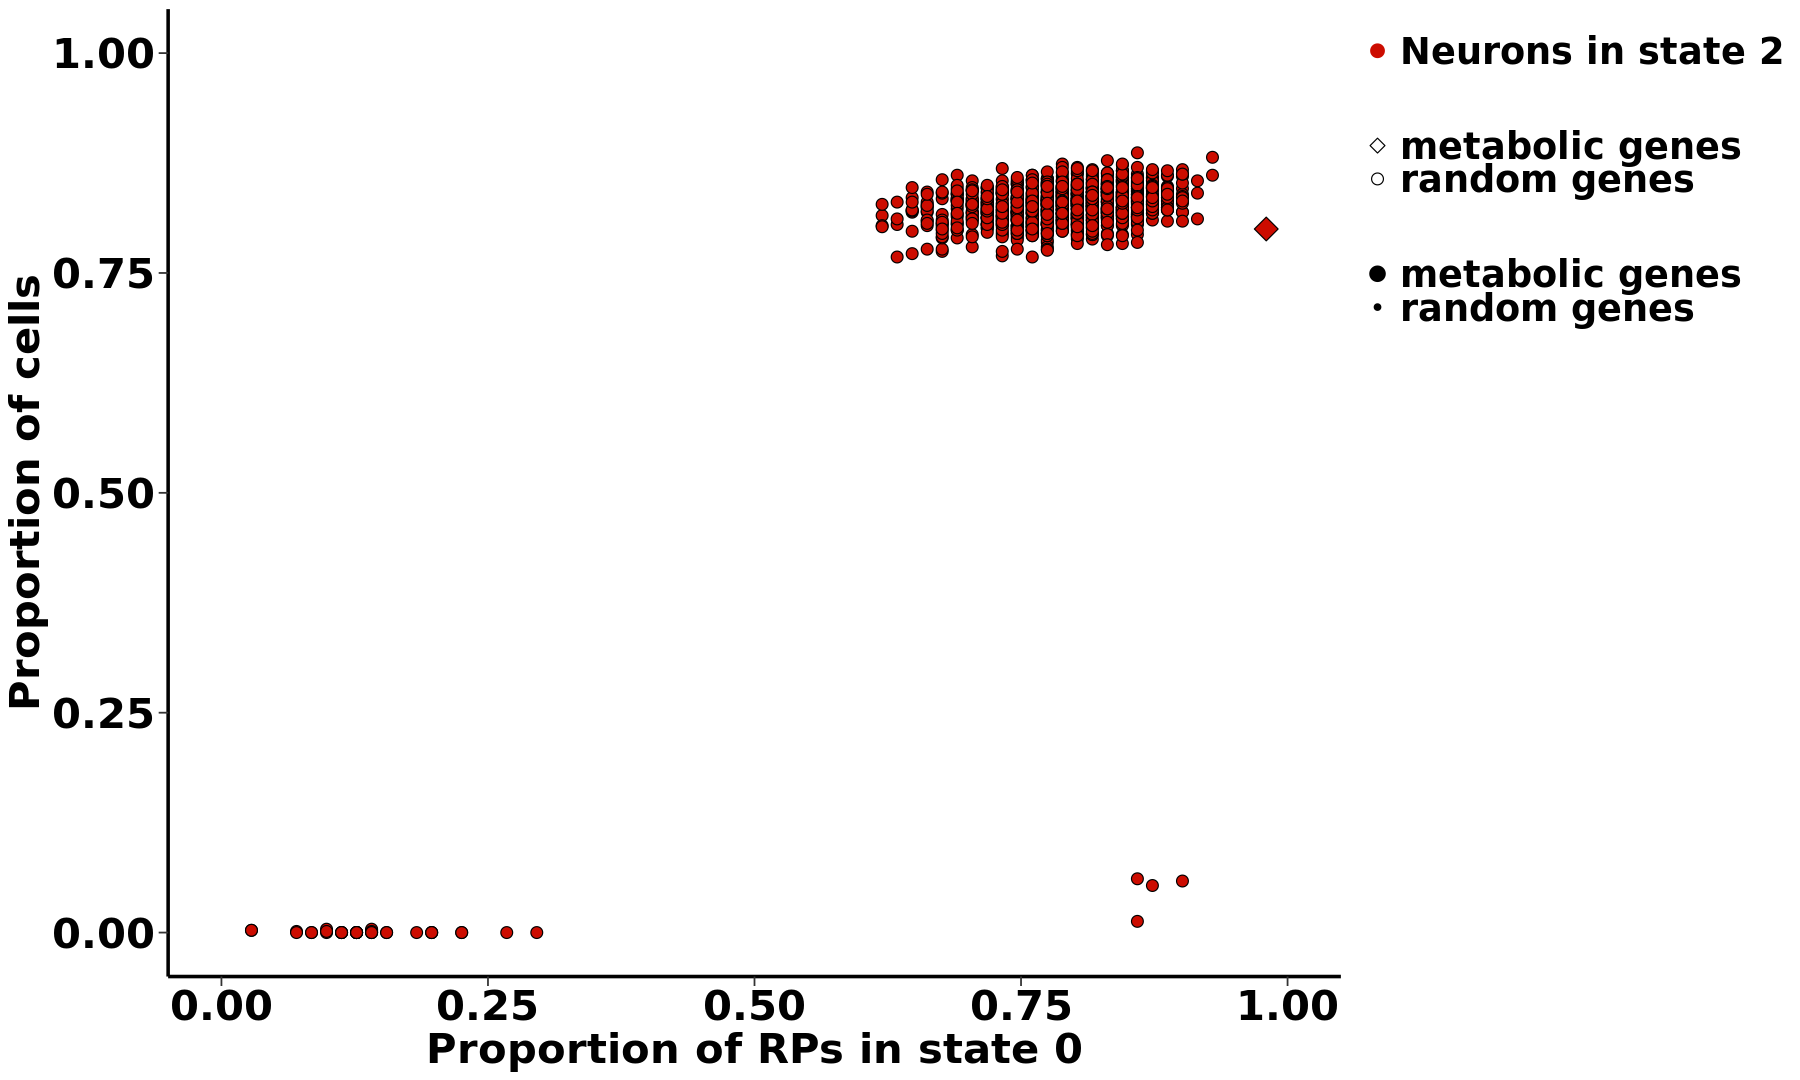

In [84]:
grid.arrange(pp)